In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_16_02_11
NN-MODEL FILENAME:  ./models/STI6WR1Z_16_02_11_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 30
LO_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  30


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
    my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     my_Q_TABLE = np.load(my_QFILE)
    my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

#     LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX, LENGTH_ABS_MAX)
#     LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
my_dqn = D3QN()
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

#  # SET STATE VALUE BORDERS
# ###############################################
# [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#  C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
# ###############################################

# # CREATE STATE COMBINATIONS
# ###############################################

# init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
#                                     [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
#                                     [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
# ###############################################

# # GET Q-VALUES 
# start = timeit.default_timer()
# % memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
# stop = timeit.default_timer()
# print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# # SAVE QFILE
# for node_id in range(NO_OF_NODES):
#     node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     np.save(node_QFILE, init_q_table)
# #############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.1
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 21798 EXPERIENCES:0:00:17.999854


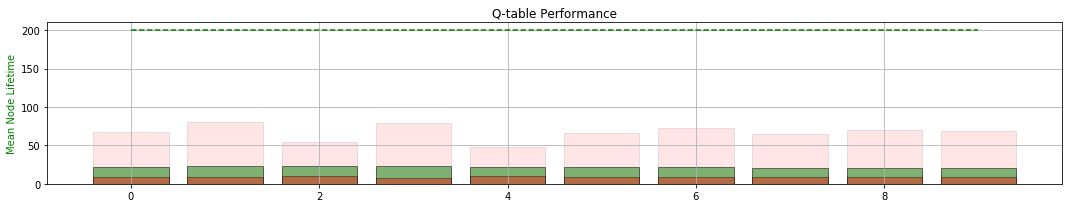

GOOD MEMORY COUNTER:  20798
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  154.245
Validating... MEAN TIME:  151.655
Validating... MEAN TIME:  138.22
Validating... MEAN TIME:  128.365
Validating... MEAN TIME:  126.965
TRAINING TIME:0:00:37.545973


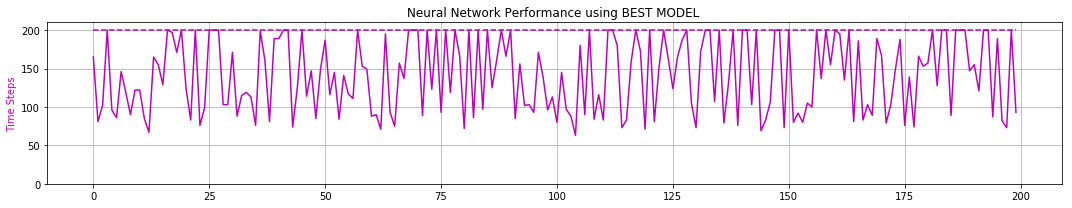

0 -max- [ 0.580  1.703  0.209  2.241  0.475]
0 -min- [-0.142 -1.369 -0.209 -2.631  0.426]

1 -max- [ 0.429  2.324  0.209  2.082  0.523]
1 -min- [-0.349 -1.330 -0.209 -2.877  0.477]

2 -max- [ 0.539  2.707  0.209  2.069  0.575]
2 -min- [-0.225 -1.201 -0.209 -3.271  0.526]

3 -max- [ 0.649  1.867  0.208  2.205  0.624]
3 -min- [-0.347 -1.564 -0.209 -2.236  0.575]

4 -max- [ 0.386  2.071  0.208  2.766  0.675]
4 -min- [-0.160 -1.776 -0.209 -2.735  0.625]

5 -max- [ 0.338  1.610  0.208  2.503  0.725]
5 -min- [-0.236 -1.786 -0.209 -2.492  0.675]

6 -max- [ 0.785  1.918  0.204  1.543  0.774]
6 -min- [-0.419 -1.504 -0.209 -2.465  0.726]

7 -max- [ 0.364  1.704  0.206  2.385  0.825]
7 -min- [-0.498 -1.533 -0.209 -2.456  0.775]

8 -max- [ 0.860  2.645  0.208  1.851  0.872]
8 -min- [-0.198 -1.182 -0.209 -2.852  0.825]

9 -max- [ 0.427  1.708  0.209  2.657  0.925]
9 -min- [-0.312 -1.948 -0.209 -2.490  0.875]



ITERATION # 1
MEAN TABULAR EPSILON =  0.4
TABULAR LR      =  0.1
SMALLEST TIMESTEP in IT

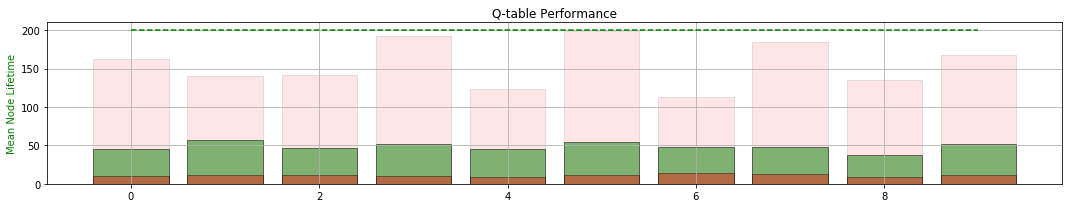

GOOD MEMORY COUNTER:  68255
BAD MEMORY COUNTER:  2000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  135.73
Validating... MEAN TIME:  136.58
Validating... MEAN TIME:  139.355
Validating... MEAN TIME:  143.695
Validating... MEAN TIME:  173.13
TRAINING TIME:0:00:38.995453


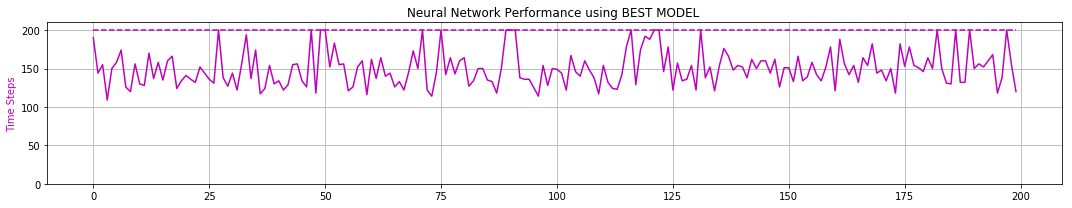

0 -max- [ 0.866  1.874  0.209  2.281  0.474]
0 -min- [-1.074 -1.885 -0.209 -2.283  0.426]

1 -max- [ 0.986  1.936  0.209  2.022  0.523]
1 -min- [-0.908 -1.879 -0.209 -2.160  0.475]

2 -max- [ 0.703  2.116  0.209  1.895  0.574]
2 -min- [-0.862 -1.843 -0.209 -2.408  0.526]

3 -max- [ 0.907  1.485  0.205  1.962  0.625]
3 -min- [-1.058 -2.250 -0.209 -1.911  0.575]

4 -max- [ 0.531  1.564  0.209  2.114  0.674]
4 -min- [-0.592 -1.541 -0.209 -1.893  0.625]

5 -max- [ 0.549  1.523  0.205  1.623  0.725]
5 -min- [-0.923 -2.047 -0.209 -1.959  0.675]

6 -max- [ 1.098  2.059  0.208  1.817  0.775]
6 -min- [-0.676 -1.500 -0.209 -2.235  0.726]

7 -max- [ 1.653  2.045  0.208  1.913  0.825]
7 -min- [-0.698 -1.699 -0.209 -1.854  0.776]

8 -max- [ 2.374  3.126  0.208  2.066  0.874]
8 -min- [-0.618 -1.904 -0.209 -2.792  0.825]

9 -max- [ 0.847  1.906  0.209  2.163  0.925]
9 -min- [-0.610 -1.650 -0.209 -2.063  0.876]



ITERATION # 2
MEAN TABULAR EPSILON =  0.6000000000000001
TABULAR LR      =  0.1
SMALLEST

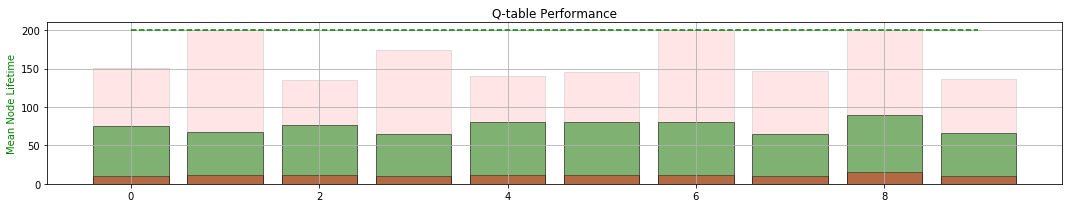

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2997
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  139.58
Validating... MEAN TIME:  176.895
Validating... MEAN TIME:  145.62
Validating... MEAN TIME:  156.685
Validating... MEAN TIME:  158.545
TRAINING TIME:0:00:40.971168


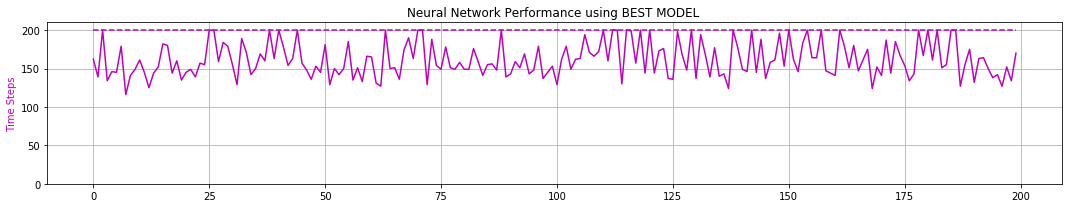

0 -max- [ 0.223  1.380  0.133  1.689  0.475]
0 -min- [-1.992 -2.702 -0.209 -2.039  0.426]

1 -max- [ 0.949  1.705  0.203  1.348  0.524]
1 -min- [-1.839 -2.716 -0.209 -2.064  0.476]

2 -max- [ 0.181  1.162  0.151  1.518  0.575]
2 -min- [-2.131 -2.804 -0.209 -1.805  0.525]

3 -max- [ 0.328  1.384  0.204  1.626  0.625]
3 -min- [-1.730 -2.352 -0.209 -2.199  0.576]

4 -max- [ 0.202  1.524  0.201  1.547  0.674]
4 -min- [-1.810 -2.578 -0.209 -1.973  0.626]

5 -max- [ 0.274  1.416  0.209  1.699  0.725]
5 -min- [-1.838 -2.592 -0.209 -2.268  0.676]

6 -max- [ 0.518  1.194  0.147  1.671  0.775]
6 -min- [-1.606 -2.363 -0.209 -1.969  0.725]

7 -max- [ 0.271  1.384  0.204  2.248  0.825]
7 -min- [-1.646 -2.407 -0.209 -2.172  0.775]

8 -max- [ 0.608  1.328  0.208  1.833  0.875]
8 -min- [-2.098 -2.848 -0.209 -2.086  0.825]

9 -max- [ 1.176  1.555  0.206  1.822  0.925]
9 -min- [-1.648 -2.249 -0.209 -2.150  0.876]



ITERATION # 3
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

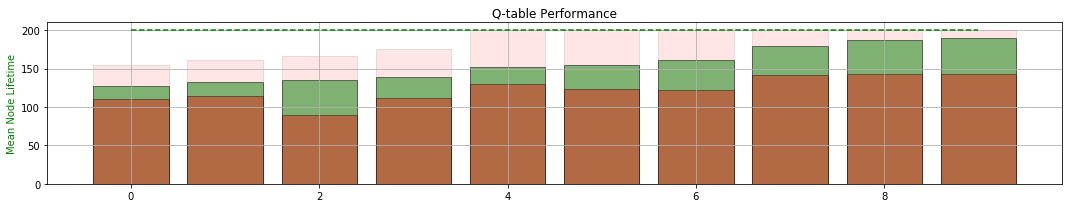

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3852
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.615
Validating... MEAN TIME:  142.495
Validating... MEAN TIME:  119.765
Validating... MEAN TIME:  133.885
Validating... MEAN TIME:  146.695
TRAINING TIME:0:00:37.132213


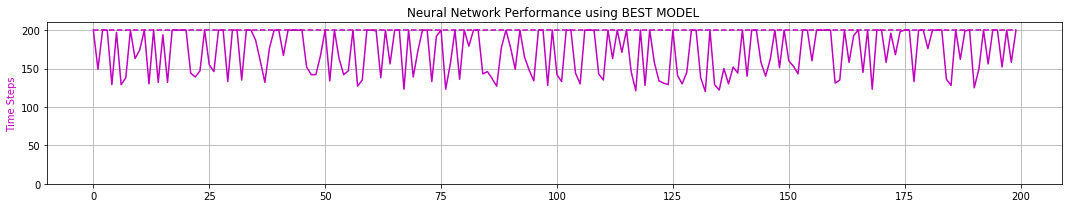

0 -max- [ 0.137  0.784  0.050  0.976  0.474]
0 -min- [-2.400 -3.364 -0.209 -1.200  0.426]

1 -max- [ 0.106  0.631  0.048  0.859  0.525]
1 -min- [-2.400 -3.340 -0.207 -1.170  0.476]

2 -max- [ 0.103  0.627  0.049  0.837  0.574]
2 -min- [-2.397 -3.334 -0.208 -1.094  0.525]

3 -max- [ 0.117  0.633  0.050  0.844  0.625]
3 -min- [-2.400 -3.330 -0.204 -1.055  0.575]

4 -max- [ 0.105  0.629  0.050  0.745  0.675]
4 -min- [-2.400 -3.152 -0.208 -0.932  0.626]

5 -max- [ 0.138  0.629  0.049  0.768  0.725]
5 -min- [-2.400 -3.123 -0.209 -1.082  0.676]

6 -max- [ 0.563  0.960  0.052  0.879  0.775]
6 -min- [-2.400 -2.968 -0.209 -1.448  0.725]

7 -max- [ 0.855  0.625  0.048  0.827  0.825]
7 -min- [-2.400 -2.946 -0.209 -1.148  0.775]

8 -max- [ 0.817  0.806  0.050  0.832  0.875]
8 -min- [-2.399 -2.952 -0.206 -0.922  0.825]

9 -max- [ 2.090  1.702  0.126  1.064  0.923]
9 -min- [-2.398 -2.963 -0.208 -1.138  0.875]



ITERATION # 4
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

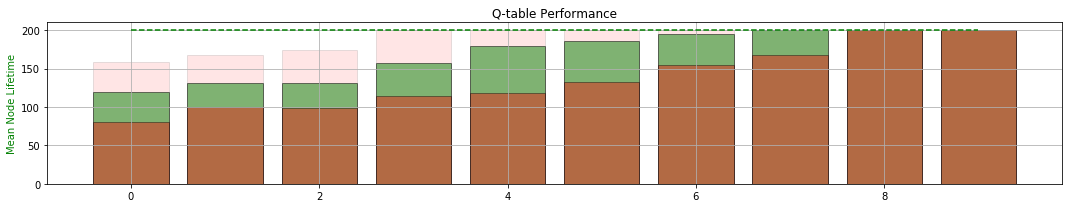

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4363
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.565
Validating... MEAN TIME:  150.53
Validating... MEAN TIME:  183.27
TRAINING TIME:0:00:47.293768


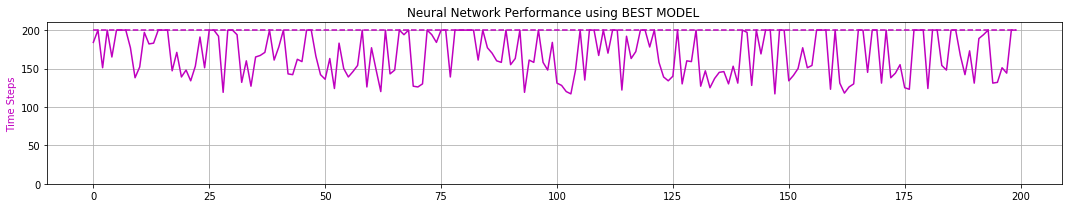

0 -max- [ 0.117  0.624  0.048  0.736  0.475]
0 -min- [-2.363 -2.950 -0.209 -0.930  0.428]

1 -max- [ 0.110  0.789  0.049  0.769  0.524]
1 -min- [-2.362 -2.915 -0.209 -1.105  0.475]

2 -max- [ 0.122  0.631  0.050  0.725  0.575]
2 -min- [-2.374 -2.788 -0.209 -1.150  0.525]

3 -max- [ 0.122  0.610  0.050  0.689  0.623]
3 -min- [-2.176 -2.743 -0.209 -0.988  0.575]

4 -max- [ 0.143  0.629  0.049  0.855  0.675]
4 -min- [-2.286 -2.600 -0.209 -1.154  0.625]

5 -max- [ 0.175  0.617  0.049  0.802  0.723]
5 -min- [-2.302 -2.584 -0.209 -1.043  0.676]

6 -max- [ 0.801  0.804  0.048  0.827  0.775]
6 -min- [-2.099 -2.415 -0.209 -0.992  0.725]

7 -max- [ 1.110  1.129  0.056  0.839  0.824]
7 -min- [-1.744 -2.043 -0.209 -0.906  0.776]

8 -max- [ 1.602  0.994  0.072  0.966  0.875]
8 -min- [-1.126 -1.317 -0.146 -0.909  0.825]

9 -max- [ 1.862  1.687  0.115  1.094  0.925]
9 -min- [-0.143 -0.785 -0.069 -1.277  0.875]



ITERATION # 5
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

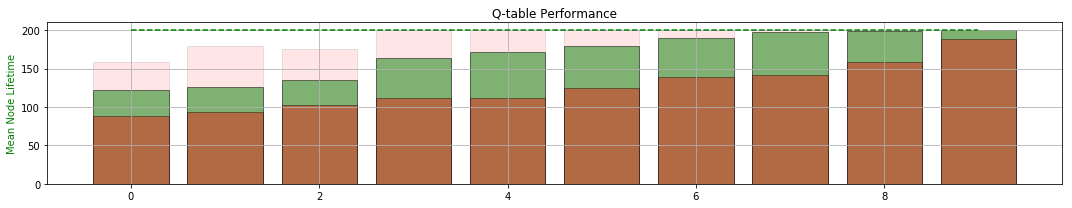

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4913
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  164.855
Validating... MEAN TIME:  183.925
Validating... MEAN TIME:  164.715
Validating... MEAN TIME:  165.34
Validating... MEAN TIME:  148.8
TRAINING TIME:0:00:43.036853


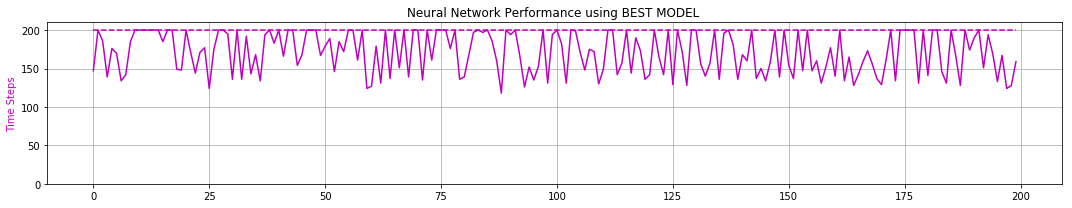

0 -max- [ 0.110  0.745  0.049  0.742  0.474]
0 -min- [-2.399 -2.963 -0.209 -1.111  0.425]

1 -max- [ 0.119  0.750  0.050  0.880  0.525]
1 -min- [-2.388 -2.972 -0.209 -1.185  0.475]

2 -max- [ 0.105  0.629  0.050  0.900  0.575]
2 -min- [-2.393 -2.961 -0.209 -0.903  0.525]

3 -max- [ 0.143  0.629  0.049  0.739  0.625]
3 -min- [-2.389 -2.788 -0.209 -0.932  0.576]

4 -max- [ 0.568  0.631  0.049  0.760  0.675]
4 -min- [-2.368 -2.789 -0.209 -1.014  0.625]

5 -max- [ 0.142  0.625  0.048  0.827  0.724]
5 -min- [-2.202 -2.576 -0.209 -1.116  0.675]

6 -max- [ 1.834  1.501  0.075  0.858  0.773]
6 -min- [-2.328 -2.586 -0.209 -0.953  0.725]

7 -max- [ 2.048  1.722  0.112  1.285  0.825]
7 -min- [-2.326 -2.587 -0.209 -1.178  0.775]

8 -max- [ 2.383  2.068  0.134  1.265  0.875]
8 -min- [-2.107 -2.400 -0.209 -1.162  0.826]

9 -max- [ 2.399  2.250  0.160  1.317  0.925]
9 -min- [-0.451 -0.629 -0.050 -1.151  0.876]



ITERATION # 6
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

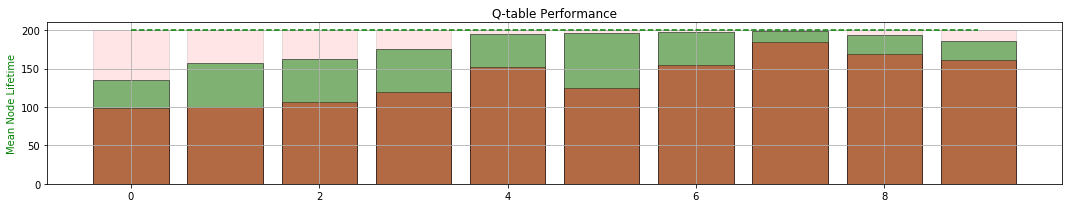

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5399
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  192.575
Validating... MEAN TIME:  181.355
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  145.89
Validating... MEAN TIME:  198.225
TRAINING TIME:0:00:45.831374


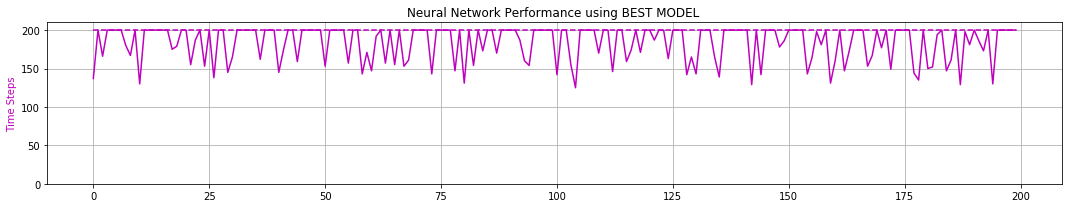

0 -max- [ 0.146  0.629  0.050  0.625  0.475]
0 -min- [-1.871 -2.586 -0.209 -0.887  0.425]

1 -max- [ 0.136  0.610  0.050  0.729  0.525]
1 -min- [-1.864 -2.543 -0.209 -0.894  0.475]

2 -max- [ 0.278  0.629  0.049  0.863  0.574]
2 -min- [-1.847 -2.420 -0.209 -0.872  0.526]

3 -max- [ 0.970  0.781  0.049  0.843  0.625]
3 -min- [-2.038 -2.594 -0.209 -0.943  0.575]

4 -max- [ 1.430  0.968  0.054  0.827  0.674]
4 -min- [-1.955 -2.407 -0.209 -0.919  0.625]

5 -max- [ 2.283  1.301  0.075  0.883  0.724]
5 -min- [-1.808 -2.230 -0.209 -1.014  0.676]

6 -max- [ 2.395  1.711  0.136  1.330  0.774]
6 -min- [-1.838 -1.863 -0.209 -1.223  0.725]

7 -max- [ 2.400  1.716  0.077  0.969  0.824]
7 -min- [-1.812 -1.669 -0.209 -1.037  0.775]

8 -max- [ 2.400  1.697  0.106  1.277  0.875]
8 -min- [-1.317 -0.938 -0.074 -0.882  0.825]

9 -max- [ 2.400  1.862  0.093  0.913  0.925]
9 -min- [-0.126 -0.631 -0.050 -0.873  0.875]



ITERATION # 7
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

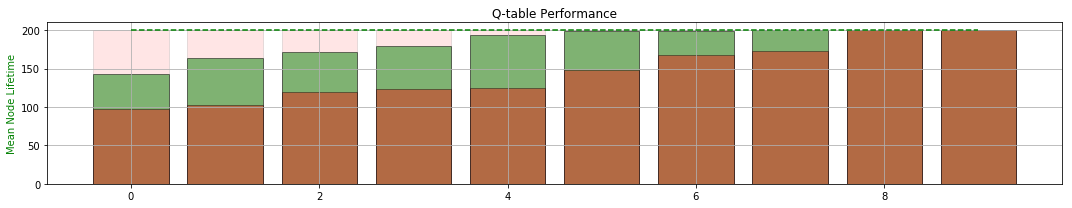

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5715
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.865
Validating... MEAN TIME:  150.325
Validating... MEAN TIME:  183.865
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  160.885
TRAINING TIME:0:00:45.617439


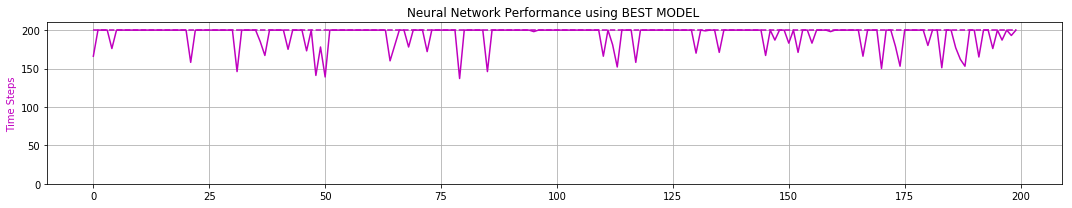

0 -max- [ 0.122  0.623  0.050  0.786  0.475]
0 -min- [-2.083 -2.740 -0.209 -1.114  0.426]

1 -max- [ 0.132  0.629  0.049  0.699  0.523]
1 -min- [-1.886 -2.414 -0.209 -0.872  0.475]

2 -max- [ 0.143  0.631  0.049  0.718  0.575]
2 -min- [-2.090 -2.557 -0.209 -0.983  0.526]

3 -max- [ 0.508  0.625  0.048  0.772  0.625]
3 -min- [-1.761 -2.205 -0.209 -0.895  0.575]

4 -max- [ 0.719  0.792  0.053  0.848  0.674]
4 -min- [-1.782 -2.203 -0.209 -0.913  0.625]

5 -max- [ 0.870  0.811  0.054  0.843  0.724]
5 -min- [-1.714 -2.055 -0.209 -0.894  0.675]

6 -max- [ 0.914  0.810  0.049  0.820  0.775]
6 -min- [-1.746 -1.844 -0.208 -0.889  0.725]

7 -max- [ 1.170  0.974  0.060  0.895  0.824]
7 -min- [-1.714 -1.674 -0.205 -0.792  0.775]

8 -max- [ 1.330  0.979  0.065  0.897  0.875]
8 -min- [-0.136 -0.631 -0.078 -0.994  0.826]

9 -max- [ 1.417  0.990  0.063  0.883  0.925]
9 -min- [-0.102 -0.617 -0.056 -0.851  0.875]



ITERATION # 8
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

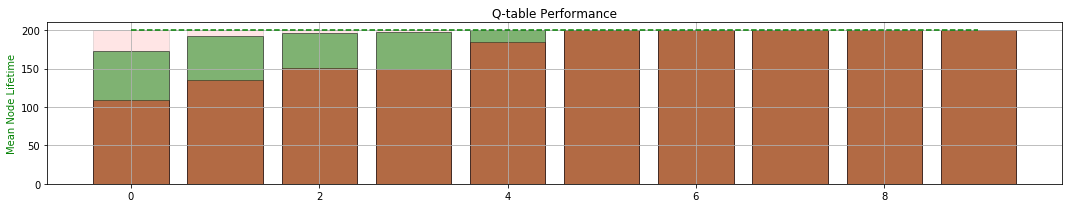

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5821
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.670289


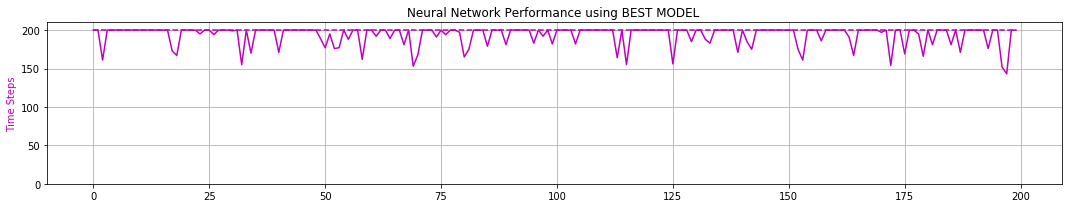

0 -max- [ 0.295  0.629  0.049  0.785  0.475]
0 -min- [-2.125 -2.595 -0.209 -0.935  0.425]

1 -max- [ 0.288  0.804  0.049  0.880  0.524]
1 -min- [-1.817 -2.222 -0.209 -1.131  0.476]

2 -max- [ 0.552  0.617  0.048  0.827  0.574]
2 -min- [-1.896 -2.200 -0.209 -0.891  0.525]

3 -max- [ 0.620  0.787  0.050  0.878  0.625]
3 -min- [-1.826 -2.213 -0.209 -0.843  0.575]

4 -max- [ 0.687  0.810  0.062  1.161  0.672]
4 -min- [-1.339 -1.308 -0.207 -0.892  0.626]

5 -max- [ 0.898  0.804  0.058  1.094  0.725]
5 -min- [-0.155 -0.785 -0.088 -0.899  0.675]

6 -max- [ 1.008  0.973  0.060  0.900  0.775]
6 -min- [-0.124 -0.737 -0.069 -1.062  0.725]

7 -max- [ 1.241  0.951  0.063  1.085  0.825]
7 -min- [-0.112 -0.796 -0.111 -1.205  0.776]

8 -max- [ 1.514  0.993  0.060  1.175  0.875]
8 -min- [-0.102 -0.739 -0.061 -0.915  0.825]

9 -max- [ 1.645  1.152  0.092  1.218  0.925]
9 -min- [-0.122 -0.647 -0.067 -0.998  0.875]



ITERATION # 9
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

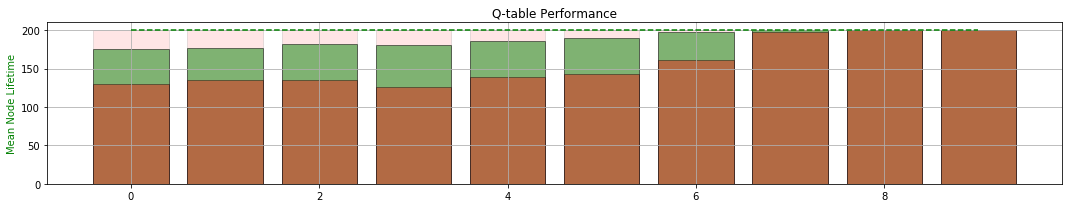

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6158
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.095
Validating... MEAN TIME:  151.83
Validating... MEAN TIME:  197.34
Validating... MEAN TIME:  199.665
Validating... MEAN TIME:  199.74
TRAINING TIME:0:00:48.089116


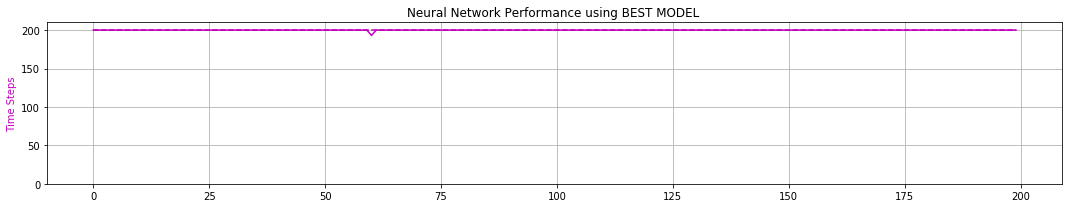

0 -max- [ 0.106  0.631  0.049  0.843  0.475]
0 -min- [-2.187 -2.549 -0.209 -1.292  0.425]

1 -max- [ 0.118  0.634  0.048  0.781  0.524]
1 -min- [-2.179 -2.559 -0.209 -0.974  0.477]

2 -max- [ 0.114  0.631  0.050  0.864  0.574]
2 -min- [-2.070 -2.423 -0.209 -0.949  0.526]

3 -max- [ 0.165  0.631  0.049  0.880  0.625]
3 -min- [-1.991 -2.392 -0.209 -1.085  0.576]

4 -max- [ 0.126  0.634  0.048  1.001  0.675]
4 -min- [-2.012 -2.391 -0.209 -1.316  0.627]

5 -max- [ 0.295  0.641  0.049  0.975  0.724]
5 -min- [-2.080 -2.383 -0.209 -1.273  0.675]

6 -max- [ 0.284  0.815  0.050  0.864  0.774]
6 -min- [-1.780 -2.069 -0.209 -1.159  0.725]

7 -max- [ 0.290  0.732  0.070  1.010  0.825]
7 -min- [-1.615 -1.877 -0.209 -1.146  0.775]

8 -max- [ 0.288  0.629  0.068  0.937  0.875]
8 -min- [-0.797 -0.812 -0.084 -0.882  0.825]

9 -max- [ 0.286  0.630  0.051  1.091  0.925]
9 -min- [-1.338 -1.472 -0.200 -0.908  0.876]



ITERATION # 10
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

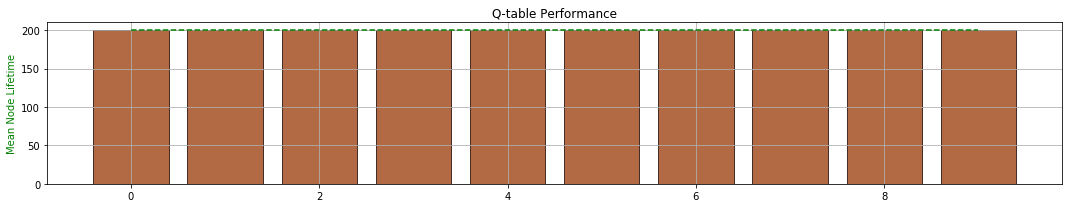

Problem SOLVED in iteration# 10


In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

#         node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
#                                             [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
#                                             [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################

#         # GET Q-VALUES 
#         %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#         # SAVE QFILE
#         node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#         np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
#     print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2079.0
Total Serial Timesteps   :  1588116.0
Speed-up                 :  763.88


In [21]:
pool.close()
pool.join()